In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from prettytable import PrettyTable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('/content/transactions_sample_100.csv')


In [14]:
# Data exploration
print("Dataset Overview:")
print(df.head())

# Preprocess the data
df.fillna(method='ffill', inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df['transaction_type'] = label_encoder.fit_transform(df['transaction_type'])

# Extract datetime features
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['hour'] = df['transaction_time'].dt.hour
df['day'] = df['transaction_time'].dt.day
df['month'] = df['transaction_time'].dt.month
df['day_of_week'] = df['transaction_time'].dt.dayofweek

# Select features and target
features = ['amount', 'transaction_type', 'customer_id', 'hour', 'day', 'month', 'day_of_week']
X = df[features]
y = df['is_fraud']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Dataset Overview:
   transaction_id  amount transaction_type  customer_id     transaction_time  \
0               1    1000         Purchase         1001  2023-01-01 10:00:00   
1               2    1500         Transfer         1002  2023-01-01 11:00:00   
2               3    2000         Purchase         1003  2023-01-01 12:00:00   
3               4    3000       Withdrawal         1004  2023-01-01 13:00:00   
4               5    5000         Transfer         1005  2023-01-01 14:00:00   

   is_fraud  
0         0  
1         1  
2         0  
3         0  
4         1  


<ipython-input-14-446feeb51dff>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the deep learning model
model = Sequential()

# Input layer with 7 features (input dimension is 7)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden layer 1
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer for regularization

# Hidden layer 2
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer for regularization

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype('int32')  # Convert probabilities to binary predictions
y_prob = model.predict(X_test)  # Probabilities for ROC AUC score

accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.4853 - loss: 0.7166 - val_accuracy: 0.4667 - val_loss: 0.7063
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5000 - loss: 0.7025 - val_accuracy: 0.6333 - val_loss: 0.6883
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4558 - loss: 0.7045 - val_accuracy: 0.6667 - val_loss: 0.6729
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5338 - loss: 0.6936 - val_accuracy: 0.7667 - val_loss: 0.6576
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5390 - loss: 0.7073 - val_accuracy: 0.8000 - val_loss: 0.6429
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5685 - loss: 0.6506 - val_accuracy: 0.8000 - val_loss: 0.6291
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4853 - loss: 0.6547 - val_accuracy: 0.8000 - val_loss: 0.6156
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6369 - loss: 0.6454 - val_accuracy: 0.8000 - val_loss: 0.6026

In [16]:
# Display model performance metrics in a table
performance_table = PrettyTable()
performance_table.field_names = ["Metric", "Value"]
performance_table.add_row(["Accuracy", f"{accuracy:.2f}"])
# performance_table.add_row(["Precision", f"{precision:.2f}"])
# performance_table.add_row(["Recall", f"{recall:.2f}"])
# performance_table.add_row(["F1-Score", f"{f1:.2f}"])
performance_table.add_row(["ROC AUC Score", f"{roc_auc:.2f}"])

print("Model Performance Metrics:")
print(performance_table)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_table = PrettyTable()
conf_matrix_table.field_names = ["", "Predicted Non-Fraud", "Predicted Fraud"]
conf_matrix_table.add_row(["Actual Non-Fraud", conf_matrix[0, 0], conf_matrix[0, 1]])
conf_matrix_table.add_row(["Actual Fraud", conf_matrix[1, 0], conf_matrix[1, 1]])

print("Confusion Matrix:")
print(conf_matrix_table)

# Apply the model to new transactions
new_transactions = pd.read_csv('/content/transactions_sample_100.csv')
new_transactions['transaction_type'] = label_encoder.transform(new_transactions['transaction_type'])
new_transactions['transaction_time'] = pd.to_datetime(new_transactions['transaction_time'])
new_transactions['hour'] = new_transactions['transaction_time'].dt.hour
new_transactions['day'] = new_transactions['transaction_time'].dt.day
new_transactions['month'] = new_transactions['transaction_time'].dt.month
new_transactions['day_of_week'] = new_transactions['transaction_time'].dt.dayofweek

new_X = new_transactions[features]
new_X_scaled = scaler.transform(new_X)

# Predict fraud
new_transactions['is_fraud'] = (model.predict(new_X_scaled) > 0.5).astype('int32')
new_transactions['fraud_probability'] = model.predict(new_X_scaled)

# Display new transactions with predictions
print("New Transactions with Fraud Predictions:")
print(new_transactions.head().to_string(index=False))

# Save the results to a CSV file
new_transactions.to_csv('predicted_fraud_transactions.csv', index=False)


Model Performance Metrics:
+---------------+-------+
|     Metric    | Value |
+---------------+-------+
|    Accuracy   |  0.87 |
| ROC AUC Score |  0.85 |
+---------------+-------+
Confusion Matrix:
+------------------+---------------------+-----------------+
|                  | Predicted Non-Fraud | Predicted Fraud |
+------------------+---------------------+-----------------+
| Actual Non-Fraud |          25         |        0        |
|   Actual Fraud   |          4          |        1        |
+------------------+---------------------+-----------------+
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
New Transactions with Fraud Predictions:
 transaction_id  amount  transaction_type  customer_id    transaction_time  is_fraud  hour  day  month  day_of_week  fraud_probability
              1    1000                 0         1001 2023-01-01 10:00:00         0    10    1      1            6           0.207570
              2    1500                 1     

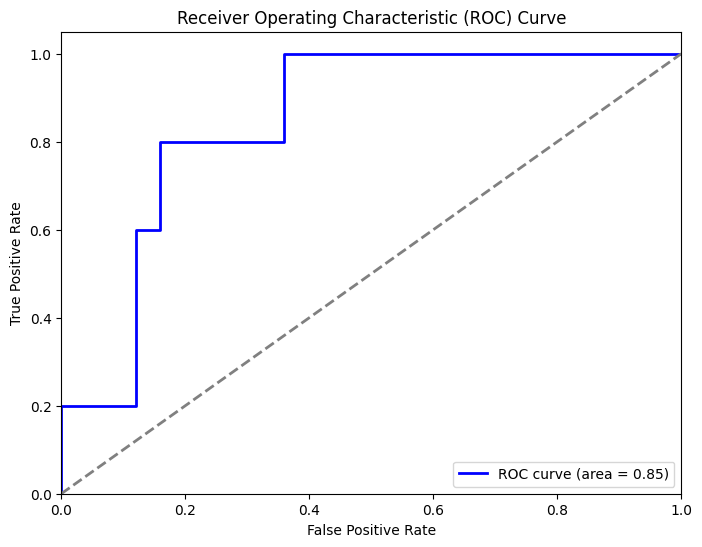

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


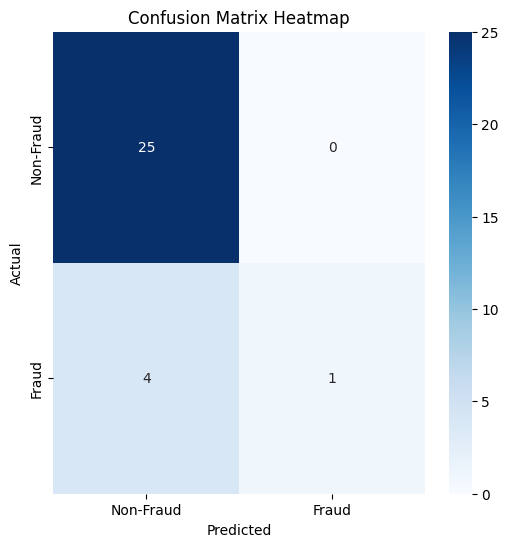

In [25]:
# Plot Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


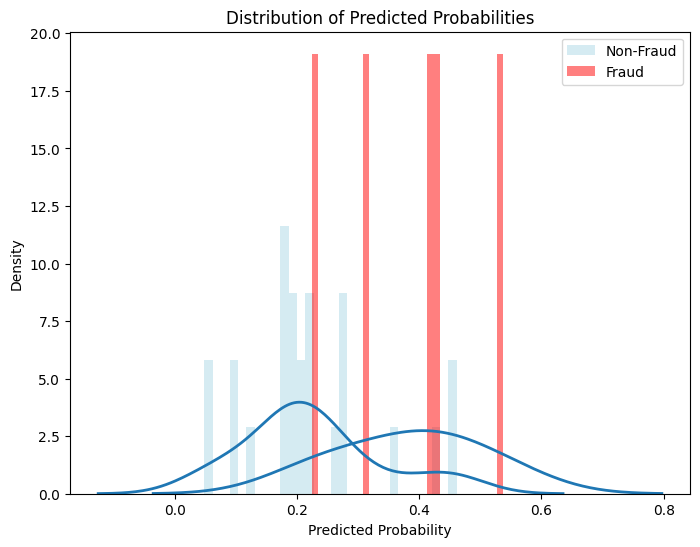

In [29]:

# Assuming y_prob and y_test are defined
plt.figure(figsize=(8, 6))

# Plot for Non-Fraud (y_test == 0)
plt.hist(y_prob[y_test == 0], bins=30, alpha=0.5, color='lightblue', label='Non-Fraud', density=True)

# Plot for Fraud (y_test == 1)
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.5, color='red', label='Fraud', density=True)

# Adding KDE to both distributions
sns.kdeplot(y_prob[y_test == 0], color='lightblue', linewidth=2)
sns.kdeplot(y_prob[y_test == 1], color='red', linewidth=2)

# Adding labels and title
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')

# Adding legend
plt.legend()

# Show the plot
plt.show()